In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

943/943 [==============================] - 1s 1ms/step - loss: 0.3822 - accuracy: 0.8341 - val_loss: 0.3476 - val_accuracy: 0.8452
Epoch 50/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3835 - accuracy: 0.8348 - val_loss: 0.3476 - val_accuracy: 0.8452
Epoch 51/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3840 - accuracy: 0.8310 - val_loss: 0.3475 - val_accuracy: 0.8452
Epoch 52/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3829 - accuracy: 0.8323 - val_loss: 0.3474 - val_accuracy: 0.8453
Epoch 53/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3832 - accuracy: 0.8327 - val_loss: 0.3474 - val_accuracy: 0.8453
Epoch 54/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3806 - accuracy: 0.8329 - val_loss: 0.3473 - val_accuracy: 0.8453
Epoch 55/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3833 - accuracy: 0.8317 - val_loss: 0.3472 - val_accuracy: 0.8454
Epoch

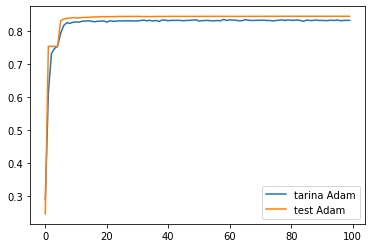

In [6]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj modelu 
```python
model.add(Dropout(0.8))
```
po każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

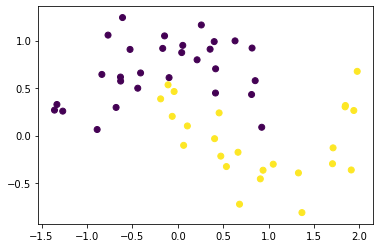

In [7]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [7]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.7367 - accuracy: 0.4906 - val_loss: 0.6756 - val_accuracy: 0.5532
Epoch 2/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.6912 - accuracy: 0.6226 - val_

Epoch 110/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0557 - accuracy: 0.9811 - val_loss: 0.2166 - val_accuracy: 0.9149
Epoch 111/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.2096 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0501 - accuracy: 1.0000 - val_loss: 0.2045 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0494 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0489 - accuracy: 1.0000 - val_loss: 0.1971 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0459 - accuracy: 1.0000 - val_loss: 0.1978 - val_accuracy: 0.9149
Epoch 116/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0458 - accuracy: 1.0000 - val_loss: 0.1941 - val_accuracy: 0.9149

2/2 [==============================] - 0s 13ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.8936
Epoch 225/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.2085 - val_accuracy: 0.9149
Epoch 226/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.2096 - val_accuracy: 0.9149
Epoch 227/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.2122 - val_accuracy: 0.9149
Epoch 228/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.2164 - val_accuracy: 0.8936
Epoch 229/1000
2/2 [==============================] - 0s 11ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.9149
Epoch 230/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.9362
Epoch 231/1000

2/2 [==============================] - 0s 13ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.2464 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2466 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2473 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2474 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2471 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2476 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2487 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 13ms/step - loss: 9.8228e-04 - accuracy: 1.0000 - val_loss: 0.2848 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 11ms/step - loss: 9.7398e-04 - accuracy: 1.0000 - val_loss: 0.2863 - val_accuracy: 0.9149
Epoch 454/1000
2/2 [==============================] - 0s 12ms/step - loss: 9.7392e-04 - accuracy: 1.0000 - val_loss: 0.2872 - val_accuracy: 0.9149
Epoch 455/1000
2/2 [==============================] - 0s 12ms/step - loss: 9.9872e-04 - accuracy: 1.0000 - val_loss: 0.2873 - val_accuracy: 0.9149
Epoch 456/1000
2/2 [==============================] - 0s 12ms/step - loss: 9.9963e-04 - accuracy: 1.0000 - val_loss: 0.2877 - val_accuracy: 0.9149
Epoch 457/1000
2/2 [==============================] - 0s 11ms/step - loss: 9.6394e-04 - accuracy: 1.0000 - val_loss: 0.2870 - val_accuracy: 0.9149
Epoch 458/1000
2/2 [==============================] - 0s 16ms/step - loss: 9.2962e-04 - accuracy: 1.0000 - val_loss: 0.2856 - val_acc

2/2 [==============================] - 0s 14ms/step - loss: 5.7533e-04 - accuracy: 1.0000 - val_loss: 0.3190 - val_accuracy: 0.9149
Epoch 563/1000
2/2 [==============================] - 0s 15ms/step - loss: 5.5953e-04 - accuracy: 1.0000 - val_loss: 0.3194 - val_accuracy: 0.9149
Epoch 564/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.6691e-04 - accuracy: 1.0000 - val_loss: 0.3198 - val_accuracy: 0.9149
Epoch 565/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.5196e-04 - accuracy: 1.0000 - val_loss: 0.3192 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 14ms/step - loss: 5.7122e-04 - accuracy: 1.0000 - val_loss: 0.3186 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.4615e-04 - accuracy: 1.0000 - val_loss: 0.3191 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 14ms/step - loss: 5.5942e-04 - accuracy: 1.0000 - val_loss: 0.3201 - val_acc

Epoch 618/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.3898e-04 - accuracy: 1.0000 - val_loss: 0.3335 - val_accuracy: 0.9149
Epoch 619/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.2946e-04 - accuracy: 1.0000 - val_loss: 0.3349 - val_accuracy: 0.9149
Epoch 620/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.5623e-04 - accuracy: 1.0000 - val_loss: 0.3367 - val_accuracy: 0.9149
Epoch 621/1000
2/2 [==============================] - 0s 14ms/step - loss: 4.3609e-04 - accuracy: 1.0000 - val_loss: 0.3370 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.3498e-04 - accuracy: 1.0000 - val_loss: 0.3367 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 13ms/step - loss: 4.4106e-04 - accuracy: 1.0000 - val_loss: 0.3362 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 12ms/step - loss: 4.2422e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 674/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.4823e-04 - accuracy: 1.0000 - val_loss: 0.3473 - val_accuracy: 0.8936
Epoch 675/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.5088e-04 - accuracy: 1.0000 - val_loss: 0.3473 - val_accuracy: 0.8936
Epoch 676/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.4762e-04 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.8936
Epoch 677/1000
2/2 [==============================] - 0s 13ms/step - loss: 3.4865e-04 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.8936
Epoch 678/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.4728e-04 - accuracy: 1.0000 - val_loss: 0.3476 - val_accuracy: 0.8936
Epoch 679/1000
2/2 [==============================] - 0s 14ms/step - loss: 3.4609e-04 - accuracy: 1.0000 - val_loss: 0.3484 - val_accuracy: 0.8936
Epoch 680/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.4050e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 730/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8715e-04 - accuracy: 1.0000 - val_loss: 0.3637 - val_accuracy: 0.8936
Epoch 731/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.9482e-04 - accuracy: 1.0000 - val_loss: 0.3630 - val_accuracy: 0.8936
Epoch 732/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8774e-04 - accuracy: 1.0000 - val_loss: 0.3633 - val_accuracy: 0.8936
Epoch 733/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8348e-04 - accuracy: 1.0000 - val_loss: 0.3633 - val_accuracy: 0.8936
Epoch 734/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.8299e-04 - accuracy: 1.0000 - val_loss: 0.3635 - val_accuracy: 0.8936
Epoch 735/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.8156e-04 - accuracy: 1.0000 - val_loss: 0.3639 - val_accuracy: 0.8936
Epoch 736/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.7992e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 786/1000
2/2 [==============================] - 0s 12ms/step - loss: 2.4293e-04 - accuracy: 1.0000 - val_loss: 0.3736 - val_accuracy: 0.8936
Epoch 787/1000
2/2 [==============================] - ETA: 0s - loss: 1.9549e-04 - accuracy: 1.00 - 0s 14ms/step - loss: 2.4401e-04 - accuracy: 1.0000 - val_loss: 0.3737 - val_accuracy: 0.8936
Epoch 788/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.3799e-04 - accuracy: 1.0000 - val_loss: 0.3745 - val_accuracy: 0.8936
Epoch 789/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.3467e-04 - accuracy: 1.0000 - val_loss: 0.3752 - val_accuracy: 0.8936
Epoch 790/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.3470e-04 - accuracy: 1.0000 - val_loss: 0.3757 - val_accuracy: 0.8936
Epoch 791/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.3222e-04 - accuracy: 1.0000 - val_loss: 0.3765 - val_accuracy: 0.8936
Epoch 792/1000
2/2 [==============================] - 0s 13ms/step - los

Epoch 897/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.7032e-04 - accuracy: 1.0000 - val_loss: 0.3976 - val_accuracy: 0.8936
Epoch 898/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.7022e-04 - accuracy: 1.0000 - val_loss: 0.3978 - val_accuracy: 0.8936
Epoch 899/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.6930e-04 - accuracy: 1.0000 - val_loss: 0.3981 - val_accuracy: 0.8936
Epoch 900/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.6864e-04 - accuracy: 1.0000 - val_loss: 0.3987 - val_accuracy: 0.8936
Epoch 901/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6706e-04 - accuracy: 1.0000 - val_loss: 0.3993 - val_accuracy: 0.8936
Epoch 902/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6726e-04 - accuracy: 1.0000 - val_loss: 0.3999 - val_accuracy: 0.8936
Epoch 903/1000
2/2 [==============================] - 0s 16ms/step - loss: 1.6619e-04 - accuracy: 1.0000 - val_loss: 0

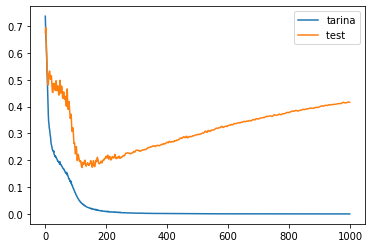

In [8]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


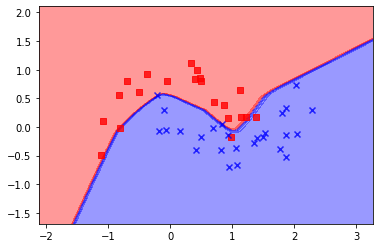

In [9]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Regularyzacja

# Zad.
Do do modelu 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [10]:
from tensorflow.keras.callbacks import History
from tensorflow.keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="sigmoid",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
